## Load Device
* Use CUDA if possible

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter 
import scipy
from matplotlib import cm as CM
import torch
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

print(torchvision.__version__)

cuda:0
0.12.0


## Apply a gaussian kernel to points in matrix
* Strength of the kernel can be adjusted using gauss_multiplier. Larger values are very expensive to compute.

In [2]:
gauss_multiplier = 0.3 # 0.1
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.vstack((np.nonzero(gt)[1], np.nonzero(gt)[0])).T

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4) # sharper 
    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3]) * gauss_multiplier
        else:
            sigma = np.average(np.array(gt.shape))/2./2. 
        density += gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

## Directories (modify as necesary)

In [3]:
import os
cwd = os.getcwd()
print(cwd)

/kaggle/working


In [4]:
# root = './ShanghaiTech/'
root = '/kaggle/input/shanghaitech/ShanghaiTech/'

In [5]:
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_train_mat = os.path.join(root,'part_A/train_data','ground-truth')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_A_test_mat = os.path.join(root,'part_A/test_data','ground-truth')

## Density plot helper

In [6]:
from sklearn import preprocessing
def plot_density_map(density):
  groundtruth = np.asarray(density)
  plt.imshow(groundtruth,cmap=CM.jet)

## Custom dataset
* loads images and mats, and calculates the gaussian kernel for each one.
* keeps a dictionary as a cache, to speed computation on repeated calls

In [7]:
import os
import pandas as pd
import fnmatch
from torchvision.io import read_image
from torchvision.io import ImageReadMode

dictCache = {}

class ImageMatDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, mat_dir, transform=None, target_transform=None):
        self.mat_dir = mat_dir
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(fnmatch.filter(os.listdir(self.img_dir), '*.*'))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"IMG_{idx+1}.jpg")
        image = read_image(img_path, mode=ImageReadMode.RGB)
        image = image.to(dtype = torch.float)
        mat_path = os.path.join(self.mat_dir, f"GT_IMG_{idx+1}.mat")

        if mat_path in dictCache:
          k = dictCache[mat_path]
        else:
          mat = io.loadmat(mat_path)
          gt = mat["image_info"][0,0][0,0][0]
          sh1 = image.shape[1]
          sh2 = image.shape[2]
          k = np.zeros((sh1,sh2))


          for i in range(0,len(gt)):
              if int(gt[i][1])<sh1 and int(gt[i][0])<sh2:
                  k[int(gt[i][1]),int(gt[i][0])]=1

          if self.target_transform:
            k = k.astype('int32')
            k = self.target_transform(k)
            k = k.cpu().detach().numpy()
            k = k.astype('float64')
            k = np.reshape(k, (k.shape[1],k.shape[2]))
            k = np.asarray(k)
                  
          # print("before gauss")
          k = gaussian_filter_density(k)

          # print("after gauss")
          # k = np.asarray(k)
          dictCache[mat_path] = k 

        if self.transform:
            image = self.transform(image)
        return image, k

## Load dataset files and apply transforms
* image is cropped to square (448px) for easier demonstration

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import multiprocessing as mp
import numpy as np
import random
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 

seed_ = 41
use_val = True
crop_size = 448

transform = transforms.Compose([
                                transforms.CenterCrop(crop_size),
                                transforms.Normalize(mean=(0,)*3, std=(255,)*3)
                              ]) 
transform2 = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.CenterCrop(crop_size),
                                transforms.ToTensor()
                              ]) 

def load_datasets():
    print("Loading Datasets...")
    dataset = ImageMatDataset(img_dir=part_A_train, mat_dir=part_A_train_mat, transform=transform, target_transform=transform2)
    dataset_sub = ImageMatDataset(img_dir=part_A_test, mat_dir=part_A_test_mat, transform=transform, target_transform=transform2)
    print("Loaded Datasets!")    
    if use_val:
        val_test_idxs = np.random.RandomState(seed=seed_).permutation(np.arange(0, len(dataset_sub)))
        val_indices =  val_test_idxs[0:int(0.60*len(val_test_idxs))]
        test_indices =  val_test_idxs[int(0.60*len(val_test_idxs)):]
        dataset_val = torch.utils.data.Subset(dataset_sub, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_sub, test_indices)
        return dataset, dataset_test, dataset_val
    else:
        dataset_test = dataset_sub
        return dataset, dataset_test, None
    
dataset, dataset_test, dataset_val = load_datasets()

Loading Datasets...
Loaded Datasets!


## Pre-calculate label density to file
uncomment and set desired gauss multiplier

In [14]:
# import pickle
# from IPython.display import clear_output

# gauss_multiplier = 0.3
# file = open("_2preCalc0_3.pck", "wb")

# print(len(dataset))
# for i in range(len(dataset)):
#   print(i)
#   print(dataset[i][1].shape)
#   clear_output(wait=True)

# print(len(dataset_test))
# for i in range(len(dataset_test)):
#   print(i)
#   print(dataset_test[i][1].shape)
#   clear_output(wait=True)

# if use_val:
#     print(len(dataset_val))
#     for i in range(len(dataset_val)):
#       print(i)
#       print(dataset_val[i][1].shape) 
#       clear_output(wait=True)
    
# pickle.dump(dictCache, file)
# file.close()

108
generate density...
done.
(448, 448)


## Load precalculated density
load from pre-calculated files, greatly speeds up model training

In [9]:
import pickle
dictCache.clear()
file = open("preCalc0_3_newcropp_with_val_final.pck", "rb") # best resuk
dictCache = pickle.load(file)
file.close()

In [11]:
len(dictCache) == 482 # should be 482 items

True

## Write Crowd Count values to file
* Using 0.3 gauss kernel power, should be the same with other values

In [34]:
with open("personActual_train.txt", "a+") as file:
    print(len(dataset))
    for i in range(len(dataset)):
        img_path = "images_train/" + f"IMG_{i+1}.jpg"
        print(i)
        source = np.sum(np.asarray(dataset[i][1]))
        print(source)
        clear_output(wait=True)
        file.write(str(img_path) + ", " + str(source)+"\n")

299
110.998245


In [41]:
with open("personActual_test.txt", "a+") as file:
    print(len(dataset))
    for i in range(len(dataset_test)):
        img_path = "images_test/" + f"IMG_{i+1}.jpg"
        print(i)
        source = np.sum(np.asarray(dataset_test[i][1]))
        print(source)
        clear_output(wait=True)
        file.write(str(img_path) + ", " + str(source)+"\n")
        j = i
        
    for i in range(len(dataset_val)):
        img_path = "images_test/" + f"IMG_{i+j+1}.jpg"
        print(i+j)
        source = np.sum(np.asarray(dataset_val[j][1]))
        print(source)
        clear_output(wait=True)
        file.write(str(img_path) + ", " + str(source)+"\n")

180
147.14827


## Sample cropped image and heat map 
* using 0.3 gaussian filter power

(143, 2)
torch.Size([3, 448, 448])
(448, 448)
crowd count: 27.202902


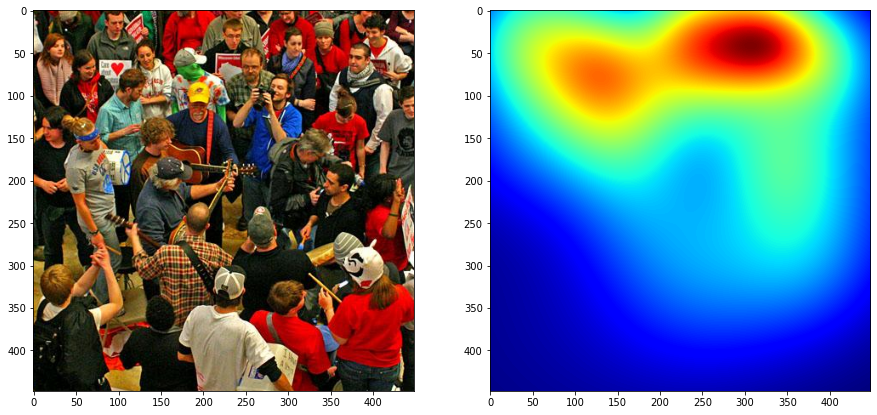

In [57]:
index = 41
images, density = dataset[index]

f, axarr = plt.subplots(1,2, figsize=(15, 15))

mat_path = os.path.join(part_A_train_mat, f"GT_IMG_{index+1}.mat")
mat = io.loadmat(mat_path)
gt = mat["image_info"][0,0][0,0][0]
print(gt.shape)
print(images.shape)
print(density.shape)

print("crowd count:", np.sum(np.asarray(density)))
axarr[0].imshow(images.permute(1, 2, 0)  )
plot_density_map(density)


## Visualize ground-truth crowd labels over image, density and measure count

(2197, 2)
generate density...
done.
0.09802248
crowd count: 2175.4514


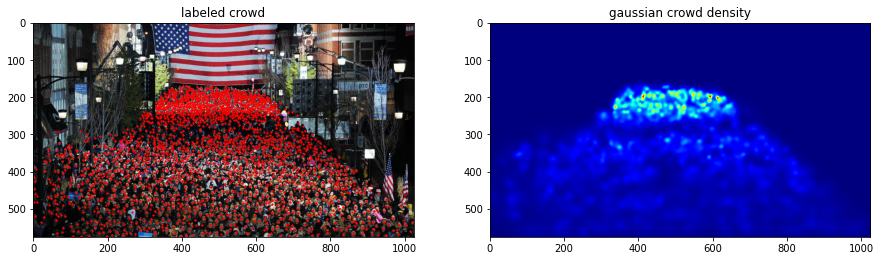

In [17]:
import matplotlib.pyplot as plt

index = 261

img_path = os.path.join(part_A_train, f"IMG_{index+1}.jpg")
image = read_image(img_path, mode=ImageReadMode.RGB)
mat_path = os.path.join(part_A_train_mat, f"GT_IMG_{index+1}.mat")
mat = io.loadmat(mat_path)
gt = mat["image_info"][0,0][0,0][0]
print(gt.shape)

f, axarr = plt.subplots(1,2, figsize=(15, 15))

sh1 = image.shape[1]
sh2 = image.shape[2]
k = np.zeros((sh1,sh2))
for i in range(0,len(gt)):
  if int(gt[i][1])<sh1 and int(gt[i][0])<sh2:
    k[int(gt[i][1]),int(gt[i][0])]=1

density = gaussian_filter_density(k)
print(np.max(np.asarray(density)))

axarr[0].imshow(image.permute(1, 2, 0)  )
axarr[0].scatter(gt.T[0],gt.T[1],c='r',s=1.5)
plot_density_map(density)
print("crowd count:", np.sum(np.asarray(density)))
axarr[0].set_title("labeled crowd")
axarr[1].set_title("gaussian crowd density")
plt.show()

## Data Loaders
* using set seed for reproducibility

In [12]:
import random
seed_ = 41
batch_size = 1 # 16
def seed_worker(worker_id):
      worker_seed = torch.initial_seed() % 2**32
      np.random.seed(worker_seed)
      random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_)

def set_data_loaders():
    val_loader = None
    #* data loaders 
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g)
    test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 
    if use_val:
        val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True, worker_init_fn=seed_worker, generator=g) 
    return train_loader, test_loader, val_loader

train_loader, test_loader, val_loader = set_data_loaders()

_________________________________________

# CNN Models for Crowd Counting

## UNet Implementation
* Extensively used for medical image segmentation, might present good results for this task

In [14]:
# 3 channel (RGB) UNet for crowd counting, 64 layer 3x3 kernels
class MyUNET(nn.Module):
  def __init__(self, **kwargs):
    super(MyUNET, self).__init__()
    k_l = 64 # kernel layers
    k_d = 3 # kernel size
    k_f = 3 # layers in rgb img

    ud_sampler = nn.Sequential(
      nn.BatchNorm2d(num_features=k_l),
      nn.ReLU(),
      nn.Conv2d(k_l, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(num_features=k_l),
      nn.ReLU()
    )
    first1 = nn.Sequential(
      nn.Conv2d(k_f, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
    ud_sampler
    )
    rest1 = nn.Sequential(
      nn.Conv2d(k_l, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
      ud_sampler
    )

    first2 = nn.Sequential(
      nn.Conv2d(k_l, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
      ud_sampler, 
      nn.Upsample(scale_factor=2)
    )

    rest2 = nn.Sequential(
      nn.Conv2d(2*k_l, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
      ud_sampler, 
      nn.Upsample(scale_factor=2)
    )

    last1 = nn.Sequential(
      nn.Conv2d(2*k_l, k_l, kernel_size=k_d, stride=1, padding=1, bias=False),
      ud_sampler,
      nn.Conv2d(k_l, 1, kernel_size=1, stride=1, bias=False),
      nn.Sigmoid()
    )
    
    self.down1 = first1
    self.down2 = rest1
    self.down3 = rest1

    self.up1 = first2
    self.up2 = rest2
    self.up3 = rest2

    self.dens = last1

  def forward(self, x: torch.Tensor):
    pool = nn.MaxPool2d(2)

    f1 = self.down1(x)
    f1_pooled = pool(f1)
    f2 = self.down2(f1_pooled)
    f2_pooled = pool(f2)

    f3 = self.down2(f2_pooled)
    f3_pooled = pool(f3)

    f4 = torch.cat([self.up1(f3_pooled), f3], dim=1) 
    f5 = torch.cat([self.up2(f4), f2], dim=1)

    f6 = torch.cat([self.up3(f5), f1], dim=1)
    f7 = self.dens(f6)

    return f7


## CSRNet implementation, incomplete
* uses dilated convolution to preserve convolution details along the forward pass

In [88]:
class MyCSRNET(nn.Module):
  def ConvReLU(self, k_f_,k_l_,k_d_,k_dil=1):
    return nn.Sequential(
      nn.Conv2d(k_f_, k_l_, kernel_size=k_d_, stride=1, padding=k_dil, dilation=k_dil),
      nn.ReLU(),
      nn.Conv2d(k_l_, k_l_, kernel_size=k_d_, stride=1, padding=k_dil, dilation=k_dil),
      nn.ReLU()
    )

  def ConvReLUSingle(self, k_f_,k_l_,k_d_,k_dil=1,k_pad=0):
    return nn.Sequential(
      nn.Conv2d(k_f_, k_l_, kernel_size=k_d_, stride=1, padding=k_dil, dilation=k_dil),
      nn.ReLU()
    )

  def __init__(self):
    super(MyCSRNET, self).__init__()
    k_l = 64 # kernel layers
    k_d = 3 # kernel size
    k_f = 3 # layers in rgb img
    self.down1 = nn.Sequential(
      self.ConvReLU(k_f,k_l,k_d),
      nn.MaxPool2d(2),
      self.ConvReLU(k_l,2*k_l,k_d),
      nn.MaxPool2d(2),
      self.ConvReLU(2*k_l,4*k_l,k_d),
      self.ConvReLUSingle(4*k_l,4*k_l,k_d),
      nn.MaxPool2d(2),
      self.ConvReLU(4*k_l,8*k_l,k_d),
      self.ConvReLUSingle(8*k_l,8*k_l,k_d),
    )

    self.up1 = nn.Sequential(
      self.ConvReLU(8*k_l,8*k_l,k_d,2),
      self.ConvReLUSingle(8*k_l,8*k_l,k_d,2),
      self.ConvReLUSingle(8*k_l,4*k_l,k_d,2),
      self.ConvReLUSingle(4*k_l,2*k_l,k_d,2),
      self.ConvReLUSingle(2*k_l,1*k_l,k_d,2),
    )

    self.dens1 = nn.Sequential(
      nn.Conv2d(k_l, 1, kernel_size=1, stride=1), 
      nn.Upsample(scale_factor=8, mode='nearest'),
      nn.Sigmoid()
    )

  def _initialize_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, std=0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

  def forward(self, x: torch.Tensor):
    f1 = self.down1(x)
    f2 = self.up1(f1)
    f3 = self.dens1(f2)
    return f3

_________________________________________

# UNet, train with validation

* Found best hyperparameters as learning_rate: 1e-8, L1 loss, SGD optimizer with 0.9 momentum and 1e-5 weight_decay.
* Learning rate will be **increased** to 1e-6 after 30 epochs
* gaussian filter power set as 0.3
* early stopping patience set as 15

## Create model, loss fn and optimizer
* Using Stochastic Gradient Descent (single sample per batch)
* Measures L1 (Mean Absolute Error) Loss 

In [16]:
model = MyUNET().to(device)

learning_rate = 1e-8 # will change to 1e-6 after n epochs
weight_decay_ = 1e-5

loss_fn = nn.L1Loss(reduction='sum') # IMPORTANT , also has to be sum
optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=weight_decay_)
use_early_stopping = True
use_val = True

In [ ]:
dataset, dataset_test, dataset_val = load_datasets()
train_loader, test_loader, val_loader = set_data_loaders()

#### sanity check

In [25]:
len(dataset_test) == 73 and len(dataset) == 300 and len(dataset_val) == 109

True

## load pre calc density (0.3)

In [26]:
import pickle
dictCache.clear()
file = open("preCalc0_3_newcropp_with_val_final.pck", "rb") # best results found with 0.3
dictCache = pickle.load(file)
file.close()

#### sanity check

In [27]:
len(dictCache) == 482

True

## Train/Val loop
* Measures validation
* Early stop behaviour
* Checkpoints to model_checkpoint.pth
* Prints current state and heat map every 100 SGD values

In [28]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import torch.nn.functional as F
from IPython.display import clear_output

model_path = "./model_checkpoint.pth"
early_stopped_at = 0
patience = 15
use_early_stopping = True

def train(model, optimizer, loss_fn, num_epochs):

  total_step = len(train_loader)
  print("total steps:", total_step)
  print("epochs:", num_epochs)

  #* Epoch loss history
  epoch_train_loss = []
  epoch_val_loss = []
  last_loss = 0
  last_vloss = 0

  #* Early stopping params
  best_score = None
  counter = 0
  global patience
  global early_stopped_at
  early_stopped_at = 0
  
  print("Training Starting...")

  for epoch in range(num_epochs):
    if epoch > 0: 
      print("last train loss:", last_loss, "last val loss:", last_vloss)
    if epoch == 30:
        # increase learning rate after initial epochs
        print(optimizer)
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-6
        print(optimizer)
        
    last_loss = 0
    last_vloss = 0
    print("\nStarting epoch:", epoch+1)
    
    #* TRAINING
    len_loss = 0
    for i, (images, density) in enumerate(train_loader):
      #* to device
      images = images.to(device)
      density = density.to(device)
      density = torch.reshape(density,(1, density.shape[0],density.shape[1],density.shape[2]))

      #* model pass
      output = model(images)
      loss   = loss_fn(output, density)
      count_actual = np.sum(np.asarray(density.cpu().detach().numpy()))
      count_pred = np.sum(np.asarray(output.cpu().detach().numpy()))

      #* change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
            
      #* add up loss
      last_loss += (loss.item())
      len_loss += 1

      if (i+1) % 100 == 0 or i == 0:
        print("\npredicted vs actual:")
        pl.clf()
        f, axarr = plt.subplots(1,3, figsize=(15, 15))
        imgtemp = images.cpu().detach()
        axarr[0].imshow(imgtemp.reshape(imgtemp.shape[1],imgtemp.shape[3],imgtemp.shape[3]).permute(1, 2, 0)  )

        temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
        sc1 = axarr[1].imshow(temp,cmap=CM.jet)
        f.colorbar(sc1, ax=axarr[1], orientation="horizontal")

        temp = np.asarray(density.detach().cpu().reshape(density.detach().cpu().shape[2],density.detach().cpu().shape[3]))
        sc2 = axarr[2].imshow(temp,cmap=CM.jet)
        f.colorbar(sc2, ax=axarr[2], orientation="horizontal")
        display.display(pl.gcf())
        plt.close()

        print ('\nEpoch [{}/{}], Step [{}/{}], Current Average Loss: {:.4f}' 
              .format(epoch+1, num_epochs, i+1, total_step, (last_loss)/(len_loss)))
        print("last MAE loss:", loss.item())
        print("last crowd count actual:", count_actual)
        print("last crowd count predicted:", count_pred)
        value_error = (count_pred-count_actual)/count_actual * 100
        print("last count estimation state:",end=" ")
        if count_pred < count_actual:
            print(f"UNDERSHOOTING by {value_error}%")
        else:
            print(f"OVERSHOOTING by {value_error}%")
            
      print("|", end ="")
      
      del images
      del density
      del output
      del loss
      torch.cuda.empty_cache()
      
    last_loss = (last_loss)/(len_loss)
    epoch_train_loss.append(last_loss)

    if use_val:
        #* VALIDATION
        with torch.no_grad():
            len_vloss = 0
            for i, (images, density) in enumerate(val_loader):
                #* to device
                images = images.to(device)
                density = density.to(device)
                density = torch.reshape(density,(1, density.shape[0],density.shape[1],density.shape[2]))


                #* forward
                output = model(images)
                vloss  = loss_fn(output, density)

                #* add up loss
                last_vloss += (vloss.item())
                len_vloss += 1

                if (i+1) % 50 == 0 or i == 0:
                      print ('\nVal Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                            .format(epoch+1, num_epochs, i+1, len(val_loader), (last_vloss)/(len_vloss)))

                print("|", end ="")

                del images
                del density
                del output
                del vloss
                torch.cuda.empty_cache()

        last_vloss = (last_vloss)/(len_vloss)
        epoch_val_loss.append(last_vloss)

    #* Early stopping
    if use_early_stopping:
        if best_score is None:
            best_score = last_vloss
        else:
            # Check if val_loss improves or not.
            if last_vloss < best_score:
                # val_loss improves, we update the latest best_score, 
                # and save the current model
                counter = 0
                best_score = last_vloss
                torch.save({'state_dict':model.state_dict()}, model_path)
            else:
                # val_loss does not improve, we increase the counter, 
                # stop training if it exceeds the amount of patience
                counter += 1
                if counter >= patience:
                    print("\tEarly Stopped")
                    early_stopped_at = epoch + 1
                    break # FOR TESTING
    
    clear_output(wait=True)

  print('\nFinished Training Trainset')
  pl.plot(range(len(epoch_train_loss)), epoch_train_loss, label="train loss") 
  pl.plot(range(len(epoch_val_loss)), epoch_val_loss, label="validation loss")
  print("last train loss:", last_loss, "last val loss:", last_vloss)
  
  if use_early_stopping: # if use_val
    if num_epochs != 0:
        print('loading best model before testing.')
        model_checkpoint = torch.load(model_path)
        model.load_state_dict(model_checkpoint['state_dict'])

    
  return epoch_train_loss, epoch_val_loss

## Train the model for up to 160 epochs

last train loss: 86.33459384918213 last val loss: 119.4201568988485

Starting epoch: 138

predicted vs actual:


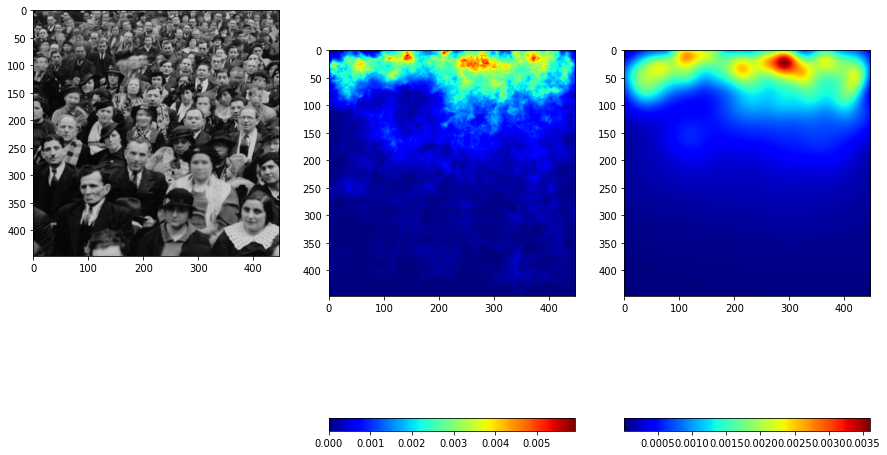


Epoch [138/160], Step [1/300], Current Average Loss: 42.2854
last MAE loss: 42.28536605834961
last crowd count actual: 105.85356
last crowd count predicted: 133.87479
last count estimation state: OVERSHOOTING by 26.471689343452454%
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
predicted vs actual:


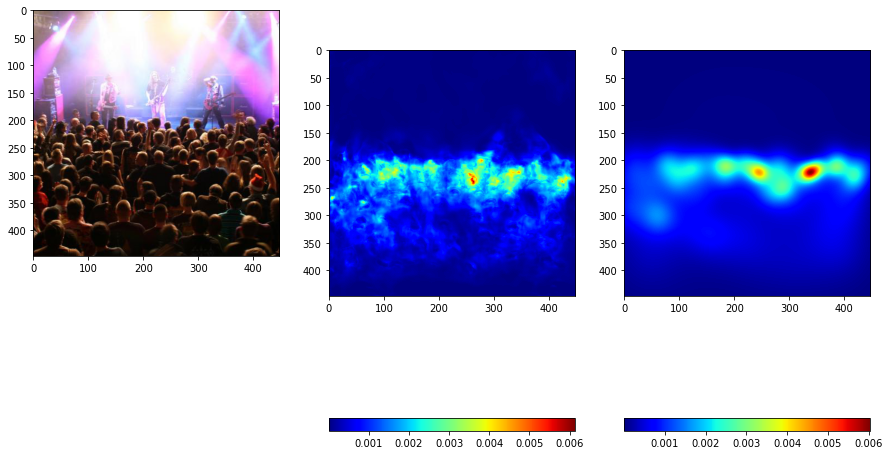


Epoch [138/160], Step [100/300], Current Average Loss: 73.5060
last MAE loss: 37.118473052978516
last crowd count actual: 100.86653
last crowd count predicted: 98.4401
last count estimation state: UNDERSHOOTING by -2.40558460354805%
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
predicted vs actual:


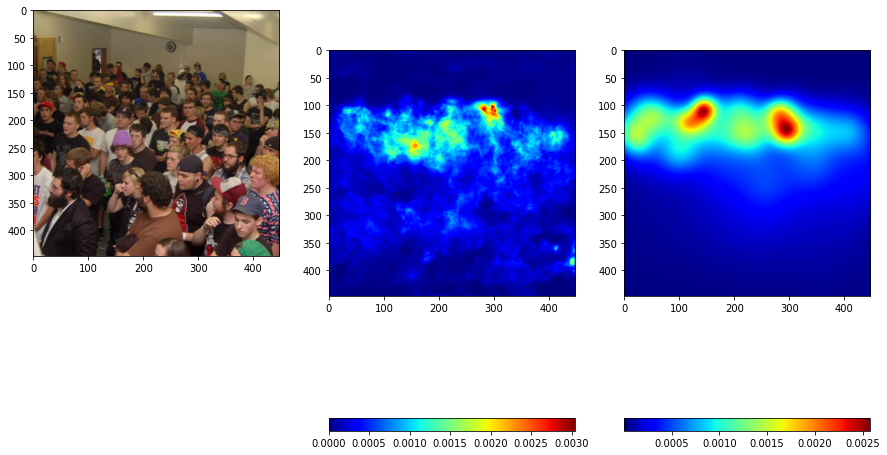


Epoch [138/160], Step [200/300], Current Average Loss: 82.4704
last MAE loss: 36.58621597290039
last crowd count actual: 71.39614
last crowd count predicted: 58.936028
last count estimation state: UNDERSHOOTING by -17.45208203792572%
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
predicted vs actual:


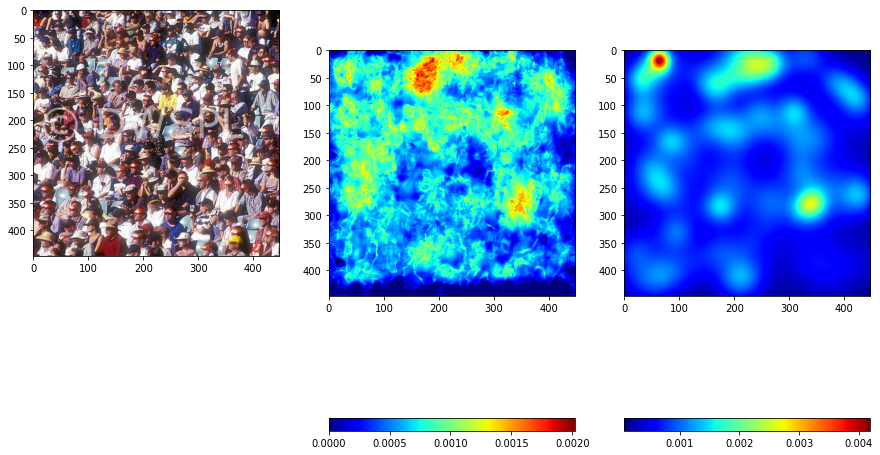


Epoch [138/160], Step [300/300], Current Average Loss: 81.5350
last MAE loss: 54.02503204345703
last crowd count actual: 169.73425
last crowd count predicted: 129.63907
last count estimation state: UNDERSHOOTING by -23.622329533100128%
|
Val Epoch [138/160], Step [1/109], Loss: 112.3386
|||||||||||||||||||||||||||||||||||||||||||||||||
Val Epoch [138/160], Step [50/109], Loss: 114.4057
||||||||||||||||||||||||||||||||||||||||||||||||||
Val Epoch [138/160], Step [100/109], Loss: 109.1684
||||||||||	Early Stopped

Finished Training Trainset
last train loss: 81.5350233745575 last val loss: 107.99154755828577
loading best model before testing.


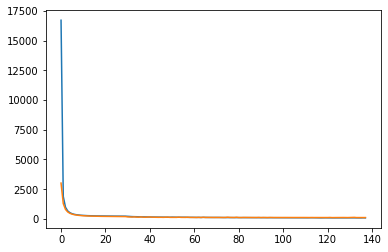

In [25]:
epoch_train_loss, epoch_val_loss = train(model, optimizer, loss_fn, 160)

## Best Result:
* last train loss: 81.5350233745575 
* last val loss: 107.99154755828577
* early stop after: 138 epochs

## Zoomed Train/Val loss graph

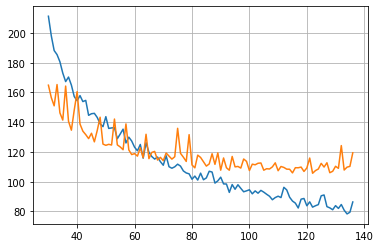

In [30]:
pl.plot(range(len(epoch_train_loss))[30:-1], epoch_train_loss[30:-1], label="train loss") 
pl.plot(range(len(epoch_val_loss))[30:-1], epoch_val_loss[30:-1], label="validation loss")
pl.grid()

## Write final model to file
Uncomment. Watch out for overwrites

In [31]:
# model_path = "./unet_best2.pth"
# torch.save({'state_dict':model.state_dict()}, model_path)

-------------------------------------

# UNet, train without validation
* We use the same hyperparameters, but using the whole test subset for the final metrics
* We set the number of epochs to the early stop value

## Create model, loss fn and optimizer
* Using Stochastic Gradient Descent (single sample per batch)
* Measures L1 (Mean Absolute Error) Loss 

In [29]:
model_noval = MyUNET().to(device)

learning_rate = 1e-8 # will change to 1e-6 after n epochs
weight_decay_ = 1e-5

loss_fn = nn.L1Loss(reduction='sum') # IMPORTANT , also has to be sum
optimizer = torch.optim.SGD(model_noval.parameters(),
                                lr=learning_rate,
                                momentum=0.9,
                                weight_decay=weight_decay_)
use_early_stopping = False
use_val = False

In [30]:
dataset, dataset_test, dataset_val = load_datasets()
train_loader, test_loader, val_loader = set_data_loaders()

Loading Datasets...
Loaded Datasets!


#### sanity check

In [31]:
len(dataset_test) == 182 and len(dataset) == 300

True

## load pre calc density (0.3)

In [32]:
import pickle
dictCache.clear()
file = open("preCalc0_3_newcropp_with_val_final.pck", "rb") # best results found with 0.3
dictCache = pickle.load(file)
file.close()

#### sanity check

In [33]:
len(dictCache) == 482

True

## Train the model for up to 138 epochs


Finished Training Trainset
last train loss: 76.86643253326416 last val loss: 0


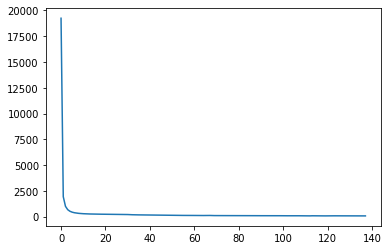

In [34]:
epoch_train_loss_noval, _ = train(model_noval, optimizer, loss_fn, 138)

## Best Result:
* last train loss: 76.86643253326416
* stop after: 138 epochs

## Zoomed Train loss graph

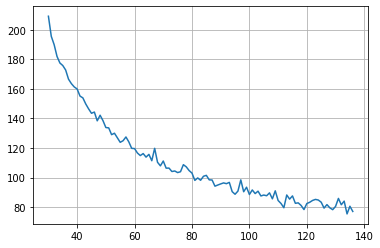

In [37]:
pl.plot(range(len(epoch_train_loss_noval))[30:-1], epoch_train_loss_noval[30:-1], label="train loss") 
pl.grid()

## Write final model to file
Uncomment. Watch out for overwrites

In [41]:
# model_path = "./unet_best_no_val2.pth"
# torch.save({'state_dict':model_noval.state_dict()}, model_path)

------------------------------------------------------

# Model Evaluation


## Load best model (no val)

In [32]:
# model_checkpoint = torch.load("./unet_best_no_val.pth")
# model_noval.load_state_dict(model_checkpoint['state_dict'])

<All keys matched successfully>

## Append predicted, actual and mae error for TRAIN

In [85]:
predicted_cnt_list = []
actual_cnt_list = []
loss_list = []
with torch.no_grad():
    len_tloss = 0
    last_tloss = 0
    with open("personUNet_train.txt", "w") as file:
        for i in range(len(dataset)):
            images, density  = dataset[i]
            #* to device
            images = images.to(device)
            images = torch.reshape(images,(1, images.shape[0],images.shape[1],images.shape[2]))
            density = torch.from_numpy(density)
            density = density.to(device)
            density = torch.reshape(density,(1, 1, density.shape[0],density.shape[1],))

            
            #* forward
            output = model_noval(images)
            vloss  = loss_fn(output, density)

            #* add up loss
            last_tloss += (vloss.item())
            len_tloss += 1
            predicted_count = np.sum(np.asarray(output.cpu()))
            actual_count = np.sum(np.asarray(density.cpu()))

            loss_list.append(vloss.item())
            predicted_cnt_list.append(predicted_count)
            actual_cnt_list.append(actual_count)

            print("|", end ="")
            
            img_path = "images_train/" + f"IMG_{i+1}.jpg"
            file.write(str(img_path) + ", " + str(predicted_count)+"\n")            
            
            del images
            del density
            del output
            del vloss
            torch.cuda.empty_cache()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

## Actual Count vs Predicted Count, Train Set

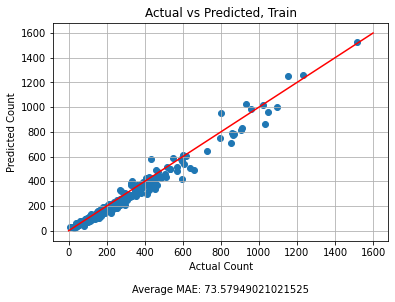

In [94]:
plt.scatter(actual_cnt_list, predicted_cnt_list)
x = np.linspace(0,1600,100)
y = x
plt.plot(x, y, '-r', label='y=x')

plt.title("Actual vs Predicted, Train")
plt.xlabel(f"Actual Count\n\nAverage MAE: {sum(loss_list) / len(loss_list)}")
plt.ylabel("Predicted Count")
plt.grid()
plt.show()

## Append predicted, actual and mae error for TEST

In [90]:
predicted_cnt_list_test = []
actual_cnt_list_test = []
loss_list_test = []
with torch.no_grad():
    len_tloss = 0
    last_tloss = 0
    with open("personUNet_test.txt", "w") as file:
        for i in range(len(dataset_test)):
            images, density  = dataset_test[i]
            #* to device
            images = images.to(device)
            images = torch.reshape(images,(1, images.shape[0],images.shape[1],images.shape[2]))
            density = torch.from_numpy(density)
            density = density.to(device)
            density = torch.reshape(density,(1, 1, density.shape[0],density.shape[1],))
            
            #* forward
            output = model_noval(images)
            vloss  = loss_fn(output, density)

            #* add up loss
            last_tloss += (vloss.item())
            len_tloss += 1
            predicted_count = np.sum(np.asarray(output.cpu()))
            actual_count = np.sum(np.asarray(density.cpu()))

            loss_list_test.append(vloss.item())
            predicted_cnt_list_test.append(predicted_count)
            actual_cnt_list_test.append(actual_count)

            print("|", end ="")
            
            img_path = "images_test/" + f"IMG_{i+1}.jpg"
            file.write(str(img_path) + ", " + str(predicted_count)+"\n")            
            
            del images
            del density
            del output
            del vloss
            torch.cuda.empty_cache()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

## Actual Count vs Predicted Count, Test Set

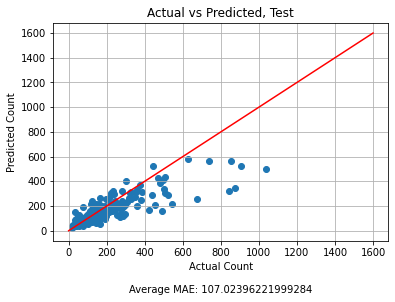

In [93]:
plt.scatter(actual_cnt_list_test, predicted_cnt_list_test)
x = np.linspace(0,1600,100)
y = x
plt.plot(x, y, '-r', label='y=x')

plt.title("Actual vs Predicted, Test")
plt.xlabel(f"Actual Count\n\nAverage MAE: {sum(loss_list_test) / len(loss_list_test)}")
plt.ylabel("Predicted Count")
plt.grid()
plt.show()

## Actual Count vs Predicted Count, Whole Set

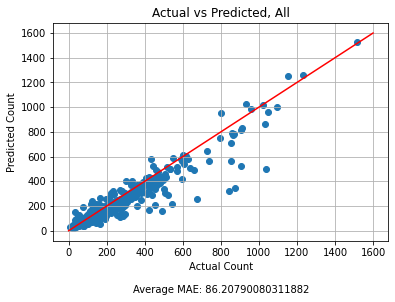

In [97]:
plt.scatter(actual_cnt_list+actual_cnt_list_test, predicted_cnt_list+predicted_cnt_list_test)
x = np.linspace(0,1600,100)
y = x
plt.plot(x, y, '-r', label='y=x')

plt.title("Actual vs Predicted, All")
plt.xlabel(f"Actual Count\n\nAverage MAE: {(sum(loss_list_test) + sum(loss_list)) / (len(loss_list_test)+ len(loss_list))}")
plt.ylabel("Predicted Count")
plt.grid()
plt.show()

------------------------------------------

## Show density of random image in test dataset

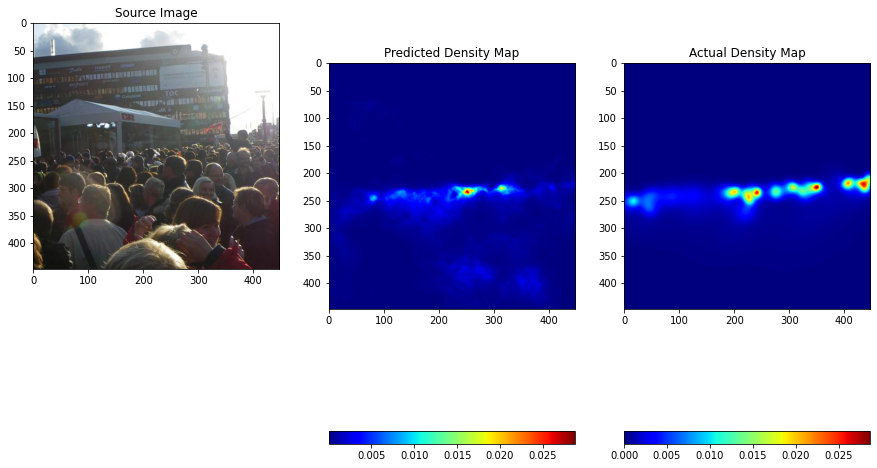

Predicted count: 93.141525 Actual count 129.09325 Current MAE 101.3050537109375


In [141]:
with torch.no_grad():
    images, density  = dataset_test[np.random.randint(len(dataset_test))]
    #* to device
    images = images.to(device)
    images = torch.reshape(images,(1, images.shape[0],images.shape[1],images.shape[2]))
    density = torch.from_numpy(density)
    density = density.to(device)
    density = torch.reshape(density,(1, 1, density.shape[0],density.shape[1],))


    #* forward
    output = model_noval(images)
    vloss  = loss_fn(output, density)

    predicted_count = np.sum(np.asarray(output.cpu()))
    actual_count = np.sum(np.asarray(density.cpu()))
    cur_loss = vloss.item()
    f, axarr = plt.subplots(1,3, figsize=(15, 15))
    imgtemp = images.cpu().detach()
    axarr[0].imshow(imgtemp.reshape(imgtemp.shape[1],imgtemp.shape[3],imgtemp.shape[3]).permute(1, 2, 0)  )
    axarr[0].title.set_text('Source Image')

    temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
    sc1 = axarr[1].imshow(temp,cmap=CM.jet)
    f.colorbar(sc1, ax=axarr[1], orientation="horizontal")
    axarr[1].title.set_text('Predicted Density Map')

    
    temp = np.asarray(density.detach().cpu().reshape(density.detach().cpu().shape[2],density.detach().cpu().shape[3]))
    sc2 = axarr[2].imshow(temp,cmap=CM.jet)
    f.colorbar(sc2, ax=axarr[2], orientation="horizontal")
    axarr[2].title.set_text('Actual Density Map')


    display.display(pl.gcf())
    plt.close()
    print("Predicted count:", predicted_count,"Actual count", actual_count, "Current MAE", cur_loss)
